In [1]:
import pandas as pd
data = pd.read_csv("survey lung cancer.csv")
data["LUNG_CANCER"][data['LUNG_CANCER']=='YES'] = 1
data["LUNG_CANCER"][data['LUNG_CANCER']=='NO'] = 0

In [3]:
data

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,F,56,1,1,1,2,2,2,1,1,2,2,2,2,1,1
305,M,70,2,1,1,1,1,2,2,2,2,2,2,1,2,1
306,M,58,2,1,1,1,1,1,2,2,2,2,1,1,2,1
307,M,67,2,1,2,1,1,2,2,1,2,2,2,1,2,1


In [4]:
from sklearn.model_selection import train_test_split
label = data['LUNG_CANCER']
data = data.drop(columns=["LUNG_CANCER"])
train_data, test_data, train_label, test_label = train_test_split(data,label,test_size=0.3,random_state=42)
train_data = train_data.reset_index().drop(columns=['index'])
test_data = test_data.reset_index().drop(columns=['index'])
train_label = train_label.reset_index().drop(columns=['index'])
test_label = test_label.reset_index().drop(columns=['index'])

In [5]:
train_all = pd.concat([train_label,train_data],axis=1)

In [6]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor(label="LUNG_CANCER").fit(train_data=train_all, auto_stack=True, hyperparameters='default', time_limit= 12*60*60, num_gpus=1)

No path specified. Models will be saved in: "AutogluonModels\ag-20230901_131052\"
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 43200s
AutoGluon will save models to "AutogluonModels\ag-20230901_131052\"
AutoGluon Version:  0.8.2
Python Version:     3.9.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   346.15 GB / 509.72 GB (67.9%)
Train Data Rows:    216
Train Data Columns: 15
Label Column: LUNG_CANCER
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators 

start predicting
[[ 5  2]
 [ 1 85]]
Accuracy: 0.967741935483871
Recall: 0.9883720930232558
F1 score: 0.9826589595375722


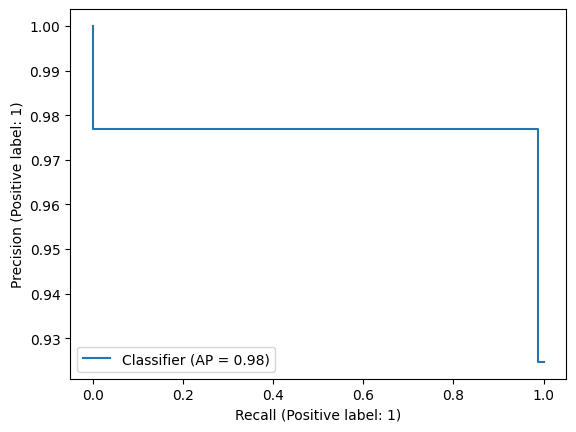

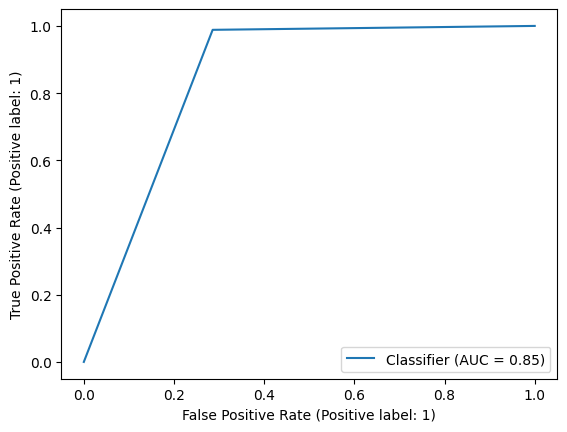

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay
import matplotlib.pyplot as plt

print('start predicting')
# from autogluon.tabular import TabularDataset, TabularPredictor
# predictor = TabularPredictor.load(r'AutogluonModels\ag-20230714_133812')
preds = predictor.predict(test_data)
test_label = test_label.astype('int64')
preds = preds.astype('int64')

test_label.astype('int64')
cm = confusion_matrix(y_true=test_label,y_pred=preds)
print(cm)
acc = accuracy_score(y_true=test_label,y_pred=preds.values)
print(f'Accuracy: {acc}')
recall = recall_score(y_true=test_label,y_pred=preds.values)
print(f'Recall: {recall}')
f1 = f1_score(y_true=test_label,y_pred=preds.values)
print(f'F1 score: {f1}')

disp = PrecisionRecallDisplay.from_predictions(y_true=test_label,y_pred=preds.values)
disp2 = RocCurveDisplay.from_predictions(y_true=test_label,y_pred=preds.values)

plt.show()

In [50]:
print(classification_report(y_true=test_label,y_pred=preds.values, target_names=["Healthy","Patient"]))

              precision    recall  f1-score   support

     Healthy       0.83      0.71      0.77         7
     Patient       0.98      0.99      0.98        86

    accuracy                           0.97        93
   macro avg       0.91      0.85      0.88        93
weighted avg       0.97      0.97      0.97        93



In [43]:
data_prob = predictor.predict_proba(test_data)[1]

submission = test_data
submission['Results'] = preds
submission['Probability'] = data_prob
submission.to_csv('survey_results.csv',index=False)

In [44]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.912037       0.834661  412.245221                0.000000           0.291065            2       True         14
1    NeuralNetFastAI_BAG_L1   0.902778       0.748562  344.146287                0.748562         344.146287            1       True         10
2   RandomForestEntr_BAG_L1   0.884259       0.037190    0.272803                0.037190           0.272803            1       True          6
3   RandomForestGini_BAG_L1   0.884259       0.038346    1.521641                0.038346           1.521641            1       True          5
4     ExtraTreesGini_BAG_L1   0.884259       0.062749    0.448728                0.062749           0.448728            1       True          8
5         LightGBMXT_BAG_L1   0.884259       0.086099   67.807869         

e:\anaconda3\envs\myenv\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.8194444444444444,
  'KNeighborsDist_BAG_L1': 0.8101851851851852,
  'LightGBMXT_BAG_L1': 0.8842592592592593,
  'LightGBM_BAG_L1': 0.8703703703703703,
  'R

In [46]:
test_all = pd.concat([test_label,test_data],axis=1)
predictor.leaderboard(test_all)

                      model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     ExtraTreesEntr_BAG_L1    0.978495   0.875000        0.031043       0.065001    0.303037                 0.031043                0.065001           0.303037            1       True          9
1     ExtraTreesGini_BAG_L1    0.978495   0.884259        0.040143       0.062749    0.448728                 0.040143                0.062749           0.448728            1       True          8
2   RandomForestEntr_BAG_L1    0.967742   0.884259        0.046757       0.037190    0.272803                 0.046757                0.037190           0.272803            1       True          6
3   RandomForestGini_BAG_L1    0.967742   0.884259        0.073650       0.038346    1.521641                 0.073650                0.038346           1.521641            1       True          5
4         Light

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr_BAG_L1,0.978495,0.875000,0.031043,0.065001,0.303037,0.031043,0.065001,0.303037,1,True,9
1,ExtraTreesGini_BAG_L1,0.978495,0.884259,0.040143,0.062749,0.448728,0.040143,0.062749,0.448728,1,True,8
2,RandomForestEntr_BAG_L1,0.967742,0.884259,0.046757,0.037190,0.272803,0.046757,0.037190,0.272803,1,True,6
3,RandomForestGini_BAG_L1,0.967742,0.884259,0.073650,0.038346,1.521641,0.073650,0.038346,1.521641,1,True,5
4,LightGBMXT_BAG_L1,0.967742,0.884259,0.132983,0.086099,67.807869,0.132983,0.086099,67.807869,1,True,3
5,WeightedEnsemble_L2,0.967742,0.912037,1.044787,0.834661,412.245221,0.002000,0.000000,0.291065,2,True,14
6,XGBoost_BAG_L1,0.967742,0.865741,1.292795,0.220394,146.746527,1.292795,0.220394,146.746527,1,True,11
7,CatBoost_BAG_L1,0.946237,0.856481,0.133201,0.345770,398.250351,0.133201,0.345770,398.250351,1,True,7
8,LightGBM_BAG_L1,0.946237,0.870370,0.179755,0.086458,61.780710,0.179755,0.086458,61.780710,1,True,4
9,NeuralNetFastAI_BAG_L1,0.946237,0.902778,0.909804,0.748562,344.146287,0.909804,0.748562,344.146287,1,True,10


In [13]:
import pandas as pd
data = pd.read_csv("survey lung cancer.csv")
data["LUNG_CANCER"][data['LUNG_CANCER']=='YES'] = 1
data["LUNG_CANCER"][data['LUNG_CANCER']=='NO'] = 0

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [7]:
sample = data[2:3]
sample

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0


In [15]:
test_data = sample.drop('LUNG_CANCER',axis=1)
test_data

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2


In [22]:
from autogluon.tabular import TabularDataset, TabularPredictor
predictor = TabularPredictor.load(r'AutogluonModels\ag-20230901_131052')
preds = predictor.predict_proba(test_data)

Found 1 mismatches between original and current metadata:
	INFO: AutoGluon Python micro version mismatch (original=3.9.17, current=3.9.18)


In [23]:
preds.iloc[0,1]

0.5008052587509155

In [ ]:
from sklearn.model_selection import train_test_split
label = data['LUNG_CANCER']
data = data.drop(columns=["LUNG_CANCER"])
train_data, test_data, train_label, test_label = train_test_split(data,label,test_size=0.3,random_state=42)
train_data = train_data.reset_index().drop(columns=['index'])
test_data = test_data.reset_index().drop(columns=['index'])
train_label = train_label.reset_index().drop(columns=['index'])
test_label = test_label.reset_index().drop(columns=['index'])